# Time Series Forecast with More Advanced RNN Methods

* Stacking
* Stacking Mixed
* Bidirectinoal
  * I think this won't be a good option for industry forecasting use cases, when it's impossible to forecast with future data in real world

In [1]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('data/pm25.csv')

print(df.shape)
df.head()

(43824, 13)


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [3]:
df.dropna(subset=['pm2.5'], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

df['datetime'] = df[['year', 'month', 'day', 'hour']].apply(
    lambda row: datetime.datetime(year=row['year'], 
                                  month=row['month'], day=row['day'],hour=row['hour']), axis=1)
df.sort_values('datetime', ascending=True, inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_pm2.5'] = scaler.fit_transform(np.array(df['pm2.5']).reshape(-1, 1))

split_date = datetime.datetime(year=2014, month=1, day=1, hour=0)  
df_train = df.loc[df['datetime']<split_date]
df_val = df.loc[df['datetime']>=split_date]
df_val.reset_index(drop=True, inplace=True)
print('Shape of train:', df_train.shape)
print('Shape of test:', df_val.shape)

Shape of train: (33096, 15)
Shape of test: (8661, 15)


In [4]:
def makeXy(ts, nb_timesteps):
    """
    Input: 
           ts: original time series
           nb_timesteps: number of time steps in the regressors
    Output: 
           X: 2-D array of regressors
           y: 1-D array of target 
    """
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        X.append(list(ts.loc[i-nb_timesteps:i-1]))
        y.append(ts.loc[i])
        
    X, y = np.array(X), np.array(y)
    return X, y

In [5]:
X_train, y_train = makeXy(df_train['scaled_pm2.5'], 7)
X_val, y_val = makeXy(df_val['scaled_pm2.5'], 7)

print('Shape of train arrays:', X_train.shape, y_train.shape)
print('Shape of validation arrays:', X_val.shape, y_val.shape)

Shape of train arrays: (33089, 7) (33089,)
Shape of validation arrays: (8654, 7) (8654,)


In [6]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
print('Shape of arrays after reshaping:', X_train.shape, X_val.shape)

Shape of arrays after reshaping: (33089, 7, 1) (8654, 7, 1)


In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU, Bidirectional
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import mean_absolute_error

tf.random.set_seed(10)

## Stacking

* Increasing network capacity is typically done by increasing the number of units in the layers, or adding more layers.
* Stacking is to add more layers

### With Linear Activation Function

In [32]:
model = Sequential()
model.add(LSTM(32,
               dropout=0.2,
               recurrent_dropout=0.5,
               return_sequences=True,
               input_shape=(X_train.shape[1:])))
model.add(LSTM(32, 
               activation='linear',
               dropout=0.2, 
               recurrent_dropout=0.5))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(amsgrad=True, learning_rate=0.1), loss='mean_absolute_error', metrics='mae')
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 7, 32)             4352      
_________________________________________________________________
lstm_25 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [33]:
save_weights_at = 'stacking_lstm_model_linear'
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            save_freq='epoch')
history = model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True)

Epoch 1/20
2069/2069 [==============================] - 22s 9ms/step - loss: 0.0961 - mae: 0.0961 - val_loss: 0.0435 - val_mae: 0.0435
INFO:tensorflow:Assets written to: stacking_lstm_model_linear\assets
Epoch 2/20
2069/2069 [==============================] - 19s 9ms/step - loss: 0.0277 - mae: 0.0277 - val_loss: 0.0356 - val_mae: 0.0356
INFO:tensorflow:Assets written to: stacking_lstm_model_linear\assets
Epoch 3/20
2069/2069 [==============================] - 18s 9ms/step - loss: 0.0267 - mae: 0.0267 - val_loss: 0.0275 - val_mae: 0.0275
INFO:tensorflow:Assets written to: stacking_lstm_model_linear\assets
Epoch 4/20
2069/2069 [==============================] - 18s 9ms/step - loss: 0.0265 - mae: 0.0265 - val_loss: 0.0172 - val_mae: 0.0172
INFO:tensorflow:Assets written to: stacking_lstm_model_linear\assets
Epoch 5/20
2069/2069 [==============================] - 25s 12ms/step - loss: 0.0242 - mae: 0.0242 - val_loss: 0.0242 - val_mae: 0.0242
Epoch 6/20
2069/2069 [==========================

MAE for the validation set: 17.0521
MAE for the scaled validation set: 0.0172


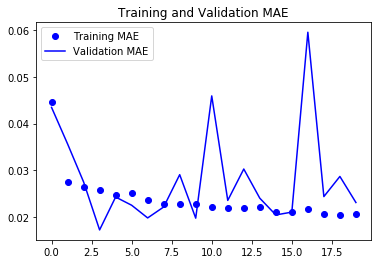

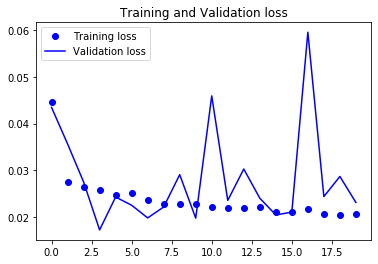

In [35]:
# load the best model
best_model = load_model('stacking_lstm_model_linear')

# Compare the prediction with y_true
preds = best_model.predict(X_val)
pred_pm25 = scaler.inverse_transform(preds)
pred_pm25 = np.squeeze(pred_pm25)

# Measure MAE of y_pred and y_true
mae = mean_absolute_error(df_val['pm2.5'].loc[7:], pred_pm25)
print('MAE for the validation set:', round(mae, 4))

mae = mean_absolute_error(df_val['scaled_pm2.5'].loc[7:], preds)
print('MAE for the scaled validation set:', round(mae, 4))

# Check the metrics and loss of each apoch
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mae))

plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.legend()

plt.figure()

# Here I was using MAE as loss too, that's why they lookedalmost the same...
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

### With Relu Activation Function

In this data, y is scaled into [0,1] range, Relu may not be the best choice

* `f(x)=max(0,x)`
  * `f(x)= x if x>= 0`
  * `f(x)=0 if x<0`

In [36]:
model = Sequential()
model.add(LSTM(32,
               dropout=0.2,
               recurrent_dropout=0.5,
               return_sequences=True,
               input_shape=(X_train.shape[1:])))
model.add(LSTM(32, 
               activation='relu',
               dropout=0.2, 
               recurrent_dropout=0.5))
model.add(Dense(1, activation='relu'))

model.compile(optimizer=Adam(amsgrad=True, learning_rate=0.1), loss='mean_absolute_error', metrics='mae')
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 7, 32)             4352      
_________________________________________________________________
lstm_27 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [37]:
save_weights_at = 'stacking_lstm_model_relu'
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            save_freq='epoch')
history = model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True)

Epoch 1/20
2069/2069 [==============================] - 22s 9ms/step - loss: 0.1147 - mae: 0.1147 - val_loss: 0.0983 - val_mae: 0.0983
INFO:tensorflow:Assets written to: stacking_lstm_model_relu\assets
Epoch 2/20
2069/2069 [==============================] - 18s 9ms/step - loss: 0.1000 - mae: 0.1000 - val_loss: 0.0983 - val_mae: 0.0983
Epoch 3/20
2069/2069 [==============================] - 18s 9ms/step - loss: 0.0996 - mae: 0.0996 - val_loss: 0.0983 - val_mae: 0.0983
Epoch 4/20
2069/2069 [==============================] - 18s 9ms/step - loss: 0.1001 - mae: 0.1001 - val_loss: 0.0983 - val_mae: 0.0983
Epoch 5/20
2069/2069 [==============================] - 25s 12ms/step - loss: 0.0991 - mae: 0.0991 - val_loss: 0.0983 - val_mae: 0.0983
Epoch 6/20
2069/2069 [==============================] - 29s 14ms/step - loss: 0.1004 - mae: 0.1004 - val_loss: 0.0983 - val_mae: 0.0983
Epoch 7/20
2069/2069 [==============================] - 30s 15ms/step - loss: 0.0994 - mae: 0.0994 - val_loss: 0.0983 - v

MAE for the validation set: 97.7571
MAE for the scaled validation set: 0.0983


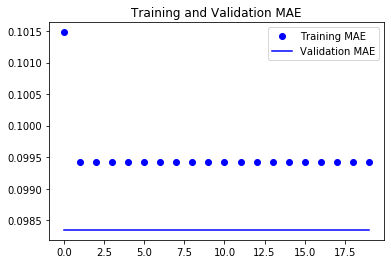

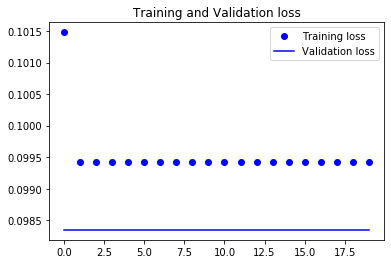

In [38]:
# load the best model
best_model = load_model('stacking_lstm_model_relu')

# Compare the prediction with y_true
preds = best_model.predict(X_val)
pred_pm25 = scaler.inverse_transform(preds)
pred_pm25 = np.squeeze(pred_pm25)

# Measure MAE of y_pred and y_true
mae = mean_absolute_error(df_val['pm2.5'].loc[7:], pred_pm25)
print('MAE for the validation set:', round(mae, 4))

mae = mean_absolute_error(df_val['scaled_pm2.5'].loc[7:], preds)
print('MAE for the scaled validation set:', round(mae, 4))

# Check the metrics and loss of each apoch
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mae))

plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.legend()

plt.figure()

# Here I was using MAE as loss too, that's why they lookedalmost the same...
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

### With Sigmoid Activation Function

* `f(x)=1/(1+e^-x)`
  * non-linear
  * y is between [0,1] range

In [49]:
model = Sequential()
model.add(LSTM(32,
               dropout=0.2,
               recurrent_dropout=0.5,
               return_sequences=True,
               input_shape=(X_train.shape[1:])))
model.add(LSTM(32, 
               activation='sigmoid',
               dropout=0.2, 
               recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(amsgrad=True, learning_rate=0.1), loss='mean_absolute_error', metrics='mae')
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 7, 32)             4352      
_________________________________________________________________
lstm_34 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [50]:
save_weights_at = 'stacking_lstm_model_sigmoid'
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            save_freq='epoch')
history = model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True)

Epoch 1/20
2069/2069 [==============================] - 55s 23ms/step - loss: 0.0954 - mae: 0.0954 - val_loss: 0.0582 - val_mae: 0.0582
INFO:tensorflow:Assets written to: stacking_lstm_model_sigmoid\assets
Epoch 2/20
2069/2069 [==============================] - 48s 23ms/step - loss: 0.0618 - mae: 0.0618 - val_loss: 0.0529 - val_mae: 0.0529
INFO:tensorflow:Assets written to: stacking_lstm_model_sigmoid\assets
Epoch 3/20
2069/2069 [==============================] - 49s 24ms/step - loss: 0.0587 - mae: 0.0587 - val_loss: 0.0494 - val_mae: 0.0494
INFO:tensorflow:Assets written to: stacking_lstm_model_sigmoid\assets
Epoch 4/20
2069/2069 [==============================] - 50s 24ms/step - loss: 0.0548 - mae: 0.0548 - val_loss: 0.0583 - val_mae: 0.0583
Epoch 5/20
2069/2069 [==============================] - 51s 25ms/step - loss: 0.0549 - mae: 0.0549 - val_loss: 0.0473 - val_mae: 0.0473
INFO:tensorflow:Assets written to: stacking_lstm_model_sigmoid\assets
Epoch 6/20
2069/2069 [==================

MAE for the validation set: 47.0309
MAE for the scaled validation set: 0.0473


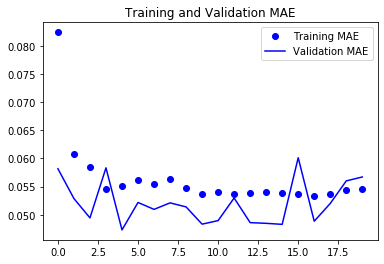

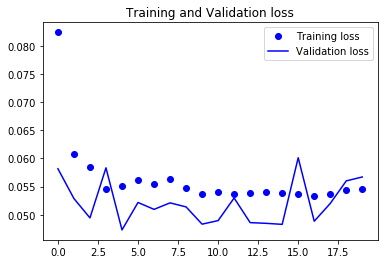

In [51]:
# load the best model
best_model = load_model('stacking_lstm_model_sigmoid')

# Compare the prediction with y_true
preds = best_model.predict(X_val)
pred_pm25 = scaler.inverse_transform(preds)
pred_pm25 = np.squeeze(pred_pm25)

# Measure MAE of y_pred and y_true
mae = mean_absolute_error(df_val['pm2.5'].loc[7:], pred_pm25)
print('MAE for the validation set:', round(mae, 4))

mae = mean_absolute_error(df_val['scaled_pm2.5'].loc[7:], preds)
print('MAE for the scaled validation set:', round(mae, 4))

# Check the metrics and loss of each apoch
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mae))

plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.legend()

plt.figure()

# Here I was using MAE as loss too, that's why they lookedalmost the same...
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

### With Tanh Activation Function

* `tanh(x)=2sigmoid(2x)-1`
  * Similar to sigmoid, but have y in [-1, 1] range, symmetric over the origin

In [43]:
model = Sequential()
model.add(LSTM(32,
               dropout=0.2,
               recurrent_dropout=0.5,
               return_sequences=True,
               input_shape=(X_train.shape[1:])))
model.add(LSTM(32, 
               activation='tanh',
               dropout=0.2, 
               recurrent_dropout=0.5))
model.add(Dense(1, activation='tanh'))

model.compile(optimizer=Adam(amsgrad=True, learning_rate=0.1), loss='mean_absolute_error', metrics='mae')
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 7, 32)             4352      
_________________________________________________________________
lstm_31 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [44]:
save_weights_at = 'stacking_lstm_model_tanh'
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            save_freq='epoch')
history = model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True)

Epoch 1/20
2069/2069 [==============================] - 22s 9ms/step - loss: 0.0676 - mae: 0.0676 - val_loss: 0.0555 - val_mae: 0.0555
INFO:tensorflow:Assets written to: stacking_lstm_model_tanh\assets
Epoch 2/20
2069/2069 [==============================] - 18s 9ms/step - loss: 0.0277 - mae: 0.0277 - val_loss: 0.0214 - val_mae: 0.0214
INFO:tensorflow:Assets written to: stacking_lstm_model_tanh\assets
Epoch 3/20
2069/2069 [==============================] - 18s 9ms/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0238 - val_mae: 0.0238
Epoch 4/20
2069/2069 [==============================] - 21s 10ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0131 - val_mae: 0.0131
INFO:tensorflow:Assets written to: stacking_lstm_model_tanh\assets
Epoch 5/20
2069/2069 [==============================] - 29s 14ms/step - loss: 0.0215 - mae: 0.0215 - val_loss: 0.0302 - val_mae: 0.0302
Epoch 6/20
2069/2069 [==============================] - 32s 15ms/step - loss: 0.0213 - mae: 0.0213 - val_loss: 0.0187 - va

MAE for the validation set: 13.0485
MAE for the scaled validation set: 0.0131


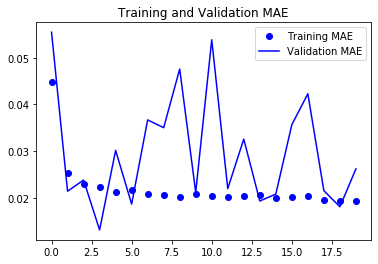

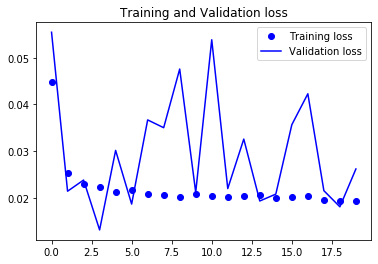

In [45]:
# load the best model
best_model = load_model('stacking_lstm_model_tanh')

# Compare the prediction with y_true
preds = best_model.predict(X_val)
pred_pm25 = scaler.inverse_transform(preds)
pred_pm25 = np.squeeze(pred_pm25)

# Measure MAE of y_pred and y_true
mae = mean_absolute_error(df_val['pm2.5'].loc[7:], pred_pm25)
print('MAE for the validation set:', round(mae, 4))

mae = mean_absolute_error(df_val['scaled_pm2.5'].loc[7:], preds)
print('MAE for the scaled validation set:', round(mae, 4))

# Check the metrics and loss of each apoch
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mae))

plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.legend()

plt.figure()

# Here I was using MAE as loss too, that's why they lookedalmost the same...
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

### With Mixed RNN models

In [46]:
model = Sequential()
model.add(LSTM(32,
               dropout=0.2,
               recurrent_dropout=0.5,
               return_sequences=True,
               input_shape=(X_train.shape[1:])))
model.add(GRU(32, 
               activation='tanh',
               dropout=0.2, 
               recurrent_dropout=0.5))
model.add(Dense(1, activation='tanh'))

model.compile(optimizer=Adam(amsgrad=True, learning_rate=0.1), loss='mean_absolute_error', metrics='mae')
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 7, 32)             4352      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 10,721
Trainable params: 10,721
Non-trainable params: 0
_________________________________________________________________


In [47]:
save_weights_at = 'stacking_lstm_model_mixed'
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            save_freq='epoch')
history = model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True)

Epoch 1/20
2069/2069 [==============================] - 24s 9ms/step - loss: 0.0466 - mae: 0.0466 - val_loss: 0.0251 - val_mae: 0.0251
INFO:tensorflow:Assets written to: stacking_lstm_model_mixed\assets
Epoch 2/20
2069/2069 [==============================] - 20s 10ms/step - loss: 0.0307 - mae: 0.0307 - val_loss: 0.0263 - val_mae: 0.0263
Epoch 3/20
2069/2069 [==============================] - 25s 12ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.0215 - val_mae: 0.0215
INFO:tensorflow:Assets written to: stacking_lstm_model_mixed\assets
Epoch 4/20
2069/2069 [==============================] - 26s 13ms/step - loss: 0.0270 - mae: 0.0270 - val_loss: 0.0157 - val_mae: 0.0157
INFO:tensorflow:Assets written to: stacking_lstm_model_mixed\assets
Epoch 5/20
2069/2069 [==============================] - 26s 13ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0359 - val_mae: 0.0359
Epoch 6/20
2069/2069 [==============================] - 26s 13ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0344

MAE for the validation set: 15.3236
MAE for the scaled validation set: 0.0154


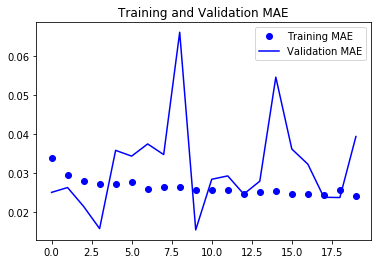

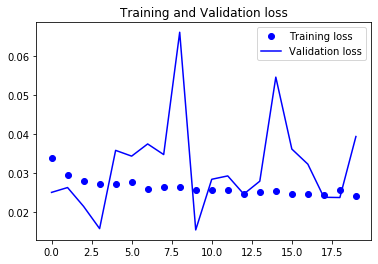

In [48]:
# load the best model
best_model = load_model('stacking_lstm_model_mixed')

# Compare the prediction with y_true
preds = best_model.predict(X_val)
pred_pm25 = scaler.inverse_transform(preds)
pred_pm25 = np.squeeze(pred_pm25)

# Measure MAE of y_pred and y_true
mae = mean_absolute_error(df_val['pm2.5'].loc[7:], pred_pm25)
print('MAE for the validation set:', round(mae, 4))

mae = mean_absolute_error(df_val['scaled_pm2.5'].loc[7:], preds)
print('MAE for the scaled validation set:', round(mae, 4))

# Check the metrics and loss of each apoch
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mae))

plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.legend()

plt.figure()

# Here I was using MAE as loss too, that's why they lookedalmost the same...
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

## Bidirectional

In [40]:
model = Sequential()
model.add(LSTM(32,
               dropout=0.2,
               recurrent_dropout=0.5,
               return_sequences=True,
               input_shape=(X_train.shape[1:])))
model.add(Bidirectional(LSTM(32, 
               activation='linear',
               dropout=0.2, 
               recurrent_dropout=0.5)))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(amsgrad=True, learning_rate=0.1), loss='mean_absolute_error', metrics='mae')
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 7, 32)             4352      
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 21,057
Trainable params: 21,057
Non-trainable params: 0
_________________________________________________________________


In [41]:
save_weights_at = 'stacking_lstm_model_bidirectional'
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            save_freq='epoch')
history = model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True)

Epoch 1/20
2069/2069 [==============================] - 32s 13ms/step - loss: 0.0992 - mae: 0.0992 - val_loss: 0.0214 - val_mae: 0.0214
INFO:tensorflow:Assets written to: stacking_lstm_model_bidirectional\assets
Epoch 2/20
2069/2069 [==============================] - 26s 12ms/step - loss: 0.0292 - mae: 0.0292 - val_loss: 0.0312 - val_mae: 0.0312
Epoch 3/20
2069/2069 [==============================] - 26s 13ms/step - loss: 0.0260 - mae: 0.0260 - val_loss: 0.0215 - val_mae: 0.0215
Epoch 4/20
2069/2069 [==============================] - 29s 14ms/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.0170 - val_mae: 0.0170
INFO:tensorflow:Assets written to: stacking_lstm_model_bidirectional\assets
Epoch 5/20
2069/2069 [==============================] - 39s 19ms/step - loss: 0.0241 - mae: 0.0241 - val_loss: 0.0242 - val_mae: 0.0242
Epoch 6/20
2069/2069 [==============================] - 40s 19ms/step - loss: 0.0235 - mae: 0.0235 - val_loss: 0.0191 - val_mae: 0.0191
Epoch 7/20
2069/2069 [==========

MAE for the validation set: 16.9019
MAE for the scaled validation set: 0.017


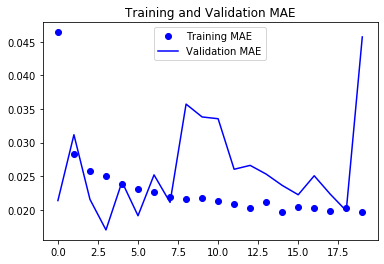

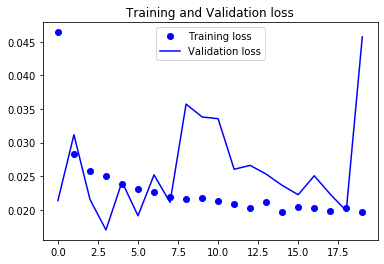

In [42]:
# load the best model
best_model = load_model('stacking_lstm_model_bidirectional')

# Compare the prediction with y_true
preds = best_model.predict(X_val)
pred_pm25 = scaler.inverse_transform(preds)
pred_pm25 = np.squeeze(pred_pm25)

# Measure MAE of y_pred and y_true
mae = mean_absolute_error(df_val['pm2.5'].loc[7:], pred_pm25)
print('MAE for the validation set:', round(mae, 4))

mae = mean_absolute_error(df_val['scaled_pm2.5'].loc[7:], preds)
print('MAE for the scaled validation set:', round(mae, 4))

# Check the metrics and loss of each apoch
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mae))

plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.legend()

plt.figure()

# Here I was using MAE as loss too, that's why they lookedalmost the same...
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()